In [1]:
#!mkdir -p ~/aiffel/dcgan_newimage/c2/generated_samples

In [2]:
#!mkdir -p ~/aiffel/dcgan_newimage/c2/training_checkpoints

In [3]:
#!mkdir -p ~/aiffel/dcgan_newimage/c2/training_history

In [4]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

print("tensorflow", tf.__version__)

tensorflow 2.4.1


In [5]:
os.getcwd()

'/aiffel/aiffel/Exp'

fashion_mnist = tf.keras.datasets.fashion_mnist #케라스에서 패션엠니스트 데이터셋 불러오기

(train_x, _), (test_x, _) = fashion_mnist.load_data() #불러서 트레인과 테스트로 나누기

In [6]:
cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

train_x.shape

(50000, 32, 32, 3)

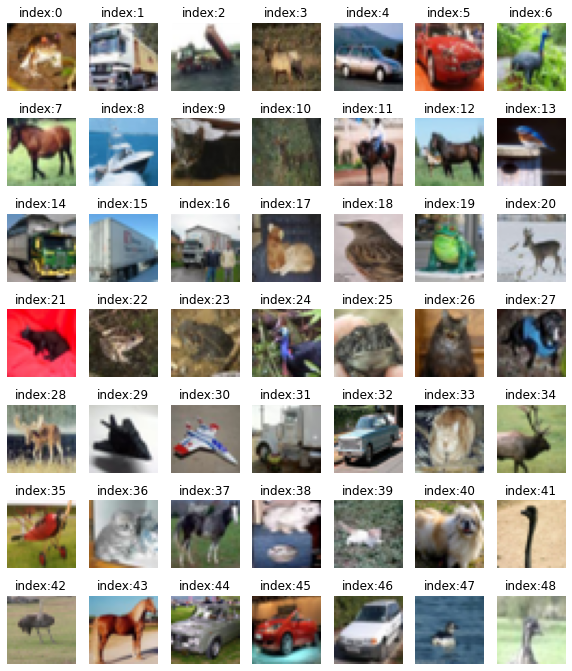

In [7]:
plt.figure(figsize=(10, 12))

for i in range(49):
    plt.subplot(7, 7, i+1) #5행5열의 이미지중 i+1번쨰에 놓는다
    plt.imshow(train_x[i], cmap = 'gray') #리사이즈한 이미지 넣기
    plt.title(f'index:{i}') #제목
    plt.axis('off') #축없앰
plt.show() #전체 그림 띄우기

In [8]:
print("max pixel:", train_x.max()) #그레이스케일 원채널이라 0~255값을 가진다
print("min pixel:", train_x.min())

max pixel: 255
min pixel: 0


In [9]:
train_x = (train_x - 127.5) / 127.5 # 이미지를 [-1, 1]로 정규화합니다. #하이퍼볼릭 탄젠트스럽네요 
#정규화 뒤에 그림이 열화된다 그렇다고 안할수도없고
print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 1.0
min pixel: -1.0


In [10]:
train_x.shape

(50000, 32, 32, 3)

In [11]:
train_x = train_x.reshape(train_x.shape[0], 32,32,3).astype('float32')
print(train_x.shape)


(50000, 32, 32, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

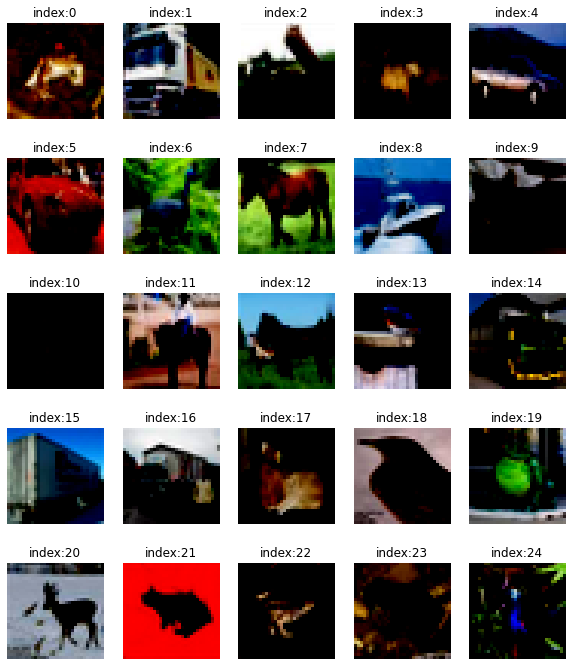

In [12]:
plt.figure(figsize=(10, 12))

for i in range(25):
    plt.subplot(5, 5, i+1) #5행5열의 이미지중 i+1번쨰에 놓는다
    plt.imshow(train_x[i])
               #, cmap = 'gray') #리사이즈한 이미지 넣기
    plt.title(f'index:{i}') #제목
    plt.axis('off') #축없앰
plt.show() #전체 그림 띄우기

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


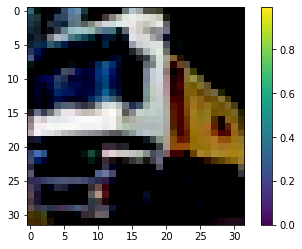

In [13]:
plt.imshow(train_x[1]) 
           #cmap='gray'
          
plt.colorbar()
plt.show()

In [14]:
BUFFER_SIZE = 50000 #50000으로하면 전체 데이터를 섞음 데이터 개수 60000이기 때문 
#데이터가 가위바위보 이런순으로 정렬되어있을수 있기때문에 전체를 섞어주는것이 좋은 학습이 된다
BATCH_SIZE = 128 #한번에 처리할 일의양

In [15]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE) #실행
# https://www.tensorflow.org/api_docs/python/tf/data/Dataset#from_tensor_slices
# https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle
# https://www.tensorflow.org/api_docs/python/tf/data/Dataset#batch

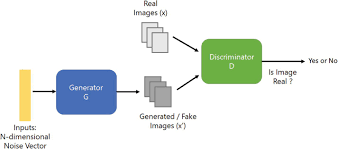

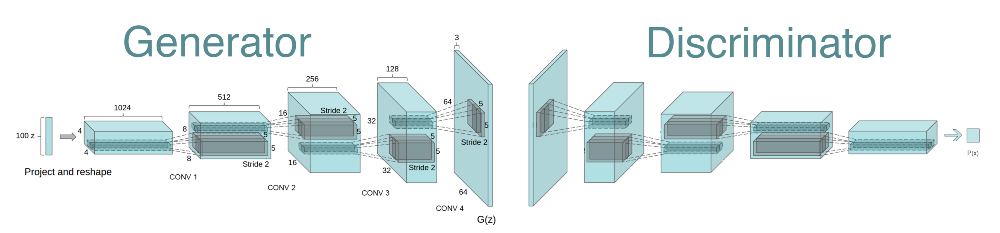

In [16]:
# 32 32 3 버젼
def make_generator_model():

    # Start
    model = tf.keras.Sequential()
#dense레이어
# #첫번째 인자 : 출력 뉴런의 수를 설정합니다.
# input_dim : 입력 뉴런의 수를 설정합니다.
# init : 가중치 초기화 방법 설정합니다.
# ‘uniform’ : 균일 분포
# ‘normal’ : 가우시안 분포
# activation : 활성화 함수 설정합니다.
# ‘linear’ : 디폴트 값, 입력뉴런과 가중치로 계산된 결과값이 그대로 출력으로 나옵니다.
# ‘relu’ : rectifier 함수, 은익층에 주로 쓰입니다.
# ‘sigmoid’ : 시그모이드 함수, 이진 분류 문제에서 출력층에 주로 쓰입니다.
# ‘softmax’ : 소프트맥스 함수, 다중 클래스 분류 문제에서 출력층에 주로 쓰입니다.
    # First: Dense layer
    model.add(layers.Dense(8*8*256, input_shape=(100,))) #가정- 7*7*256은 트렌콘부 3번의 업샘플링을 통해 출력모양 28.28.1로 만들기 위해 계산된 수
    model.add(layers.BatchNormalization()) #미니배치를 통한 정규화
    model.add(layers.LeakyReLU()) #활성화함수

    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 256)))

    # Third: Conv2DTranspose layer# 업샘플링을한다
    model.add(layers.Conv2DTranspose(128, kernel_size=(3, 3), strides=(1, 1), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(128, kernel_size=(3, 3), strides=(1, 1), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(3, 3), strides=(2, 2), padding='same'))
    # output = 인풋 * 스트라이드
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fifth: Conv2DTranspose layer #출력층 모양이 32,32,3이 되게 맞춰줌
    model.add(layers.Conv2DTranspose(3,kernel_size=(3, 3), strides=(2, 2), padding='same', activation='tanh'))
#new_rows = ((rows - 1) * strides[0] + kernel_size[0] - 2 * padding[0] +output_padding[0])

    return model


def make_generator_model():

    # Start
    model = tf.keras.Sequential()
#dense레이어
# #첫번째 인자 : 출력 뉴런의 수를 설정합니다.
# input_dim : 입력 뉴런의 수를 설정합니다.
# init : 가중치 초기화 방법 설정합니다.
# ‘uniform’ : 균일 분포
# ‘normal’ : 가우시안 분포
# activation : 활성화 함수 설정합니다.
# ‘linear’ : 디폴트 값, 입력뉴런과 가중치로 계산된 결과값이 그대로 출력으로 나옵니다.
# ‘relu’ : rectifier 함수, 은익층에 주로 쓰입니다.
# ‘sigmoid’ : 시그모이드 함수, 이진 분류 문제에서 출력층에 주로 쓰입니다.
# ‘softmax’ : 소프트맥스 함수, 다중 클래스 분류 문제에서 출력층에 주로 쓰입니다.
    # First: Dense layer
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,))) #가정- 7*7*256은 트렌콘부 3번의 업샘플링을 통해 출력모양 28.28.1로 만들기 위해 계산된 수
    model.add(layers.BatchNormalization()) #미니배치를 통한 정규화
    model.add(layers.LeakyReLU()) #활성화함수

    # Second: Reshape layer
    model.add(layers.Reshape((7, 7, 256)))

    # Third: Conv2DTranspose layer# 업샘플링을한다
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    # output = 인풋 * 스트라이드
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(1, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))
#new_rows = ((rows - 1) * strides[0] + kernel_size[0] - 2 * padding[0] +output_padding[0])

    return model

(Conv2DTranspose)[https://velog.io/@hayaseleu/Transposed-Convolutional-Layer%EC%9D%80-%EB%AC%B4%EC%97%87%EC%9D%B8%EA%B0%80 ]

In [17]:
generator = make_generator_model()

generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16384)             1654784   
_________________________________________________________________
batch_normalization (BatchNo (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16384)             0         
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 128)         295040    
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 128)         0

In [18]:
noise = tf.random.normal([1, 100])
noise
#tf.random.normal( #디폴트 모양 shape는 출력모양을 뜻함 mean 평균 stddev 표준편차 dtype 파일형 seed 같은 모양을 만들수있는 랜덤 지정수
#    shape, mean=0.0, stddev=1.0, dtype=tf.dtypes.float32, seed=None, name=None
#)

<tf.Tensor: shape=(1, 100), dtype=float32, numpy=
array([[ 0.13938348,  1.2454174 , -1.7300283 ,  0.8165478 ,  0.79153   ,
         0.2779191 ,  1.0774124 , -0.91599673, -2.1693926 , -0.3708536 ,
         0.63386184,  1.1658183 , -0.04590851, -0.63486105, -1.8581278 ,
         0.2903618 , -0.45027572,  1.5497355 , -1.8763987 ,  1.1325463 ,
         0.24123012,  0.37245947, -0.01347213,  0.5076592 ,  0.1620566 ,
        -1.2789284 , -0.5564918 , -0.04463641, -1.2087146 ,  0.47362545,
        -0.6311142 ,  0.47290146, -1.7042636 , -0.7583275 ,  1.3495347 ,
         0.92186767,  0.3814716 ,  0.4045984 ,  2.2024899 ,  0.03524204,
         0.97873247,  0.4103636 ,  0.24800949, -1.0931859 , -2.774149  ,
        -0.6294417 , -0.551429  ,  1.2498565 ,  0.25405368, -0.37764582,
        -0.42242432,  0.00698051,  0.54285234, -0.2851897 ,  0.18056796,
         0.00516965, -1.0844089 , -1.3625536 , -1.8463156 ,  0.03358892,
         0.33703953,  0.526437  , -0.6989844 , -1.298644  ,  1.3789824 ,
 

In [19]:
generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

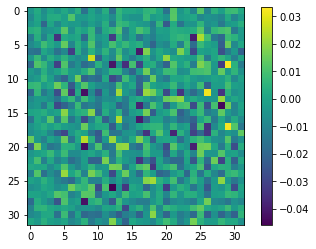

In [20]:
plt.imshow(generated_image[0, :, :, 0]
           #, cmap='gray'
          )
plt.colorbar()
plt.show()

In [21]:
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer #커널사이즈가 좀 큰거같아서 5에서 3으로 내림
    model.add(layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same', input_shape=[32, 32, 3])) #64=필터링결과물출력크기 (5,5)=커널사이즈(필터링하는 사이즈?)
    model.add(layers.LeakyReLU())

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())

    #하나더
    model.add(layers.Conv2D(256, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())

    # Third: Flatten Layer
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.3)) #층마다 있던 드랍아웃을 뒤에서 한번만하기로 했다

    # Fourth: Dense Layer
    model.add(layers.Dense(1,activation='sigmoid'))

    return model

def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1])) #64=필터링결과물출력크기 (5,5)=커널사이즈(필터링하는 사이즈?)
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model

In [22]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 64)        1792      
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 128)         73856     
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 256)         295168    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 4, 4, 256)         0         
_________________________________________________________________
flatten (Flatten)            (None, 4096)             

In [23]:
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.49993902]], dtype=float32)>

In [24]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)


In [25]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output) #ones_like 출력형태는 같되 1로 채운다


In [26]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output) #0으로 채운다
    total_loss = real_loss + fake_loss
    return total_loss


In [27]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

In [28]:
generator_optimizer = tf.keras.optimizers.Adam(1e-5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-5)

In [29]:
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

In [30]:
#@tf.function 데코레이터가 사용된 함수에 입력된 입력은 Tensorflow의 graph 노드가 될 수 있는 타입으로 자동 변환됩니다. 
#알아두면 향후 Tensorflow 모델 구현에 매우 편리하게 사용할 수 있을 것 같습니다
@tf.function# Tensorflow graph 모드를 compile함.
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

In [31]:
def generate_and_save_images(model, epoch, it, sample_seeds):
    predictions = model(sample_seeds, training=False)
    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0])
        plt.axis('off')

    plt.savefig('{}/aiffel/dcgan_newimage/c2/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))
    # matplotlib를 이용해 gif파일을 생성함.

    plt.show()

In [32]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 8    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('{}/aiffel/dcgan_newimage/c2/training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

In [33]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/c2/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)


In [34]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)

                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [35]:
save_every = 5
EPOCHS = 200 #50

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

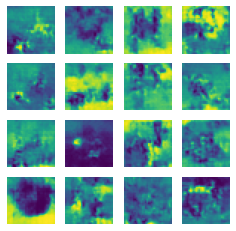

Time for training : 6814 sec


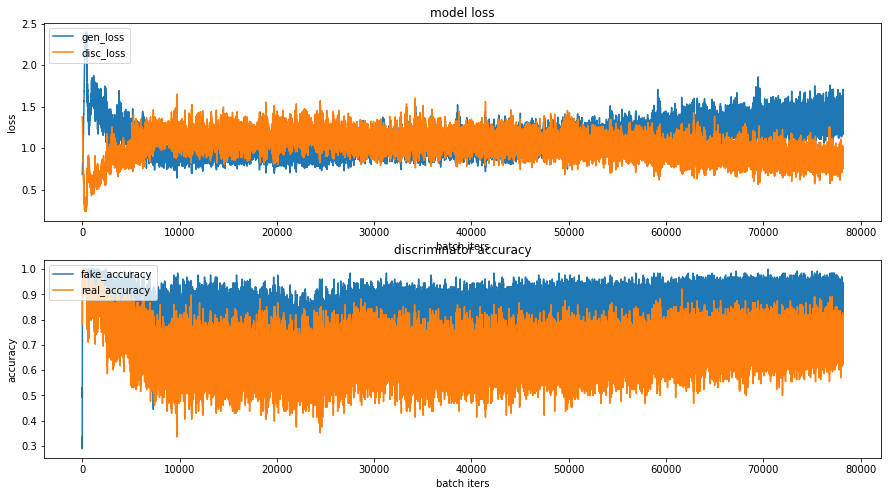

CPU times: user 58min 5s, sys: 2min 20s, total: 1h 25s
Wall time: 1h 53min 38s


In [36]:
%%time
train(train_dataset, EPOCHS, save_every)

# 학습과정의 loss, accuracy 그래프 이미지 파일이 ~/aiffel/dcgan_newimage/fashion/training_history 경로에 생성되고 있으니
# 진행 과정을 수시로 확인해 보시길 권합니다.

In [37]:
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/c2/fashion_mnist_dcgan.gif'
#gif 파일 만드는 법
with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/c2/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.7)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
#    image = imageio.imread(filename)
#    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/fashion/fashion_mnist_dcgan.gif

-rw-r--r-- 1 root root 1362775 Nov 11 09:55 /aiffel/aiffel/dcgan_newimage/fashion/fashion_mnist_dcgan.gif


STEP 1. 데이터셋 구성하기

cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

train_x.shape

학습에 사용할 train_x의 이미지를 -1, 1로 정규화합니다.
로드한 학습 데이터를 시각화를 통해 확인해 봅시다.
tf.data.Dataset 모듈의 from_tensor_slices() 함수를 사용하여 미니배치 데이터셋을 구성해 봅시다. 

STEP 2. 생성자 모델 구현하기

(32, 32, 3)의 shape를 가진 이미지를 생성하는 생성자 모델 구현 함수를 작성해 봅시다.
noise = tf.random.normal([1, 100])로 생성된 랜덤 노이즈를 입력으로 하여 방금 구현한 생성자로 랜덤 이미지를 생성해 봅시다.
생성된 랜덤 이미지가 생성자 출력 규격에 잘 맞는지 확인해 봅시다. 

STEP 3. 판별자 모델 구현하기

(32, 32, 3)의 이미지를 입력으로 받아 1dim을 판별결과를 출력하는 판별자 모델 구현 함수를 작성해 봅시다.
위 STEP 2에서 생성한 랜덤 이미지를 판별자 모델이 판별한 결과값을 확인해 봅시다. 

STEP 4. 손실함수와 최적화 함수 구현하기

생성자와 판별자의 손실함수(loss)를 구현해 봅시다.
판별자의 출력값을 가지고 실제/생성(real/fake) 이미지 판별 정확도(accuracy)를 계산하는 함수를 구현해 봅시다.
생성자와 판별자를 최적화하는 optimizer를 정의합니다. 

STEP 5. 훈련과정 상세 기능 구현하기

1개 미니배치의 훈련 과정을 처리하는 train_step() 함수를 구현해 봅시다.
16개의 고정된 seed를 입력으로 하여 훈련 과정 동안 생성한 이미지를 시각화하는 generate_and_save_images() 함수를 구현해 봅시다.
훈련 epoch마다 생성자/판별자의 loss 및 판별자의 실제/생성(real/fake) 이미지 판별 accuracy 히스토리(history)를 그래프로 시각화하는 draw_train_history() 함수를 구현해 봅시다.
training_checkpoints 디렉토리에 몇 epoch마다 모델을 저장하는 checkpoint 모듈을 설정해 봅시다. 

STEP 6. 학습 과정 진행하기

위 STEP 5에서 구현한 기능들을 활용하여 최소 50 epoch만큼의 모델 학습을 진행해 봅시다.
학습 과정에서 생성된 샘플 이미지로 만든 gif 파일을 통해 학습 진행 과정을 시각적으로 표현해 봅시다.
학습 과정을 담은 샘플 이미지, gif 파일, 학습 진행 그래프 이미지를 함께 제출합니다. 

(참고) 학습 과정 중 학습 epoch를 추가 진행해야 하거나, 학습한 모델을 활용하여 이미지를 생성할 필요가 생깁니다. 그럴 때마다 모델 학습을 처음부터 다시 진행한다면 시간 낭비가 될 것입니다. 우리는 위에서 checkpoint 모듈을 이용해 모델을 저장해 둔 바 있습니다. 이를 이용해 학습해 둔 모델을 로드하면 모델 재학습이 필요 없이 이런 작업을 진행할 수 있습니다. 아래는 checkpoint 모듈을 활용하여 모델을 로드하는 예시입니다.

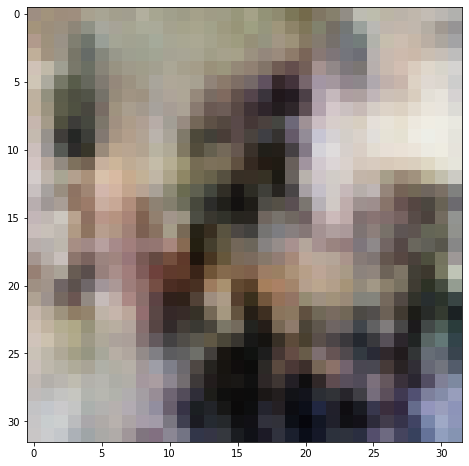

In [54]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/c2/training_checkpoints'
latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인해 봅니다. 

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
np_generated = np_generated.astype(int)

plt.imshow(np_generated[0])

plt.show()  # 정상적으로 모델이 로드되었다면 랜덤 이미지가 아니라 CIFAR-10 이미지가 그려질 것입니다.

#checkpoint를 통해 모델이 로드되었으면 아래 코드를 실행할 경우 로드된 모델의 파라미터 상태에서 훈련을 재개할 수도 있습니다.

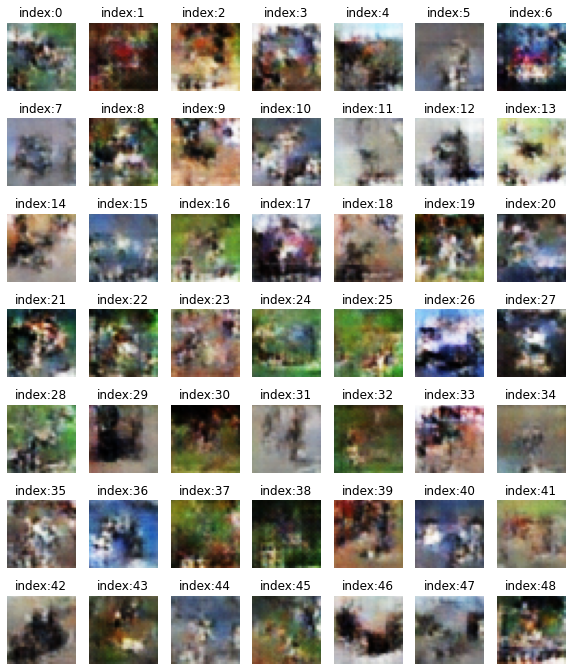

In [56]:
plt.figure(figsize=(10, 12))

for i in range(49):
    noise = tf.random.normal([1, 100])
    generated_image = generator(noise, training=False)
    np_generated = generated_image.numpy()
    np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
    np_generated = np_generated.astype(int)
    
    plt.subplot(7, 7, i+1) #5행5열의 이미지중 i+1번쨰에 놓는다
    plt.imshow(np_generated[0], cmap = 'gray') #리사이즈한 이미지 넣기
    plt.title(f'index:{i}') #제목
    plt.axis('off') #축없앰
plt.show() #전체 그림 띄우기

In [39]:
#%%time 
#train(train_dataset, EPOCHS, save_every)

STEP 7. (optional) GAN 훈련 과정 개선하기

STEP 6을 진행하면서 생성된 샘플 이미지, 학습 과정 그래프 등을 통해 이전 훈련 과정의 문제점을 분석해 봅시다.
모델구조 또는 학습 과정을 개선한 내역과 그 결과(샘플 이미지, 학습 과정 그래프 포함)를 함께 제출합니다. 

## 개선사항    
제네레이터와 디스크리미네이터의 모델을 32,32,3형태에 맞게 변형,커널사이즈를 5에서 3으로 줄임, 컨볼루션 레이어 증가, 드랍아웃 위치 및 비율 변경, 에폭수 200으로 증가, 나쁜 과거의 데이터가 이어지나 폴더도 바꿔봄

## 고찰
계속 모델링을 바꿔보며 몇 번을 돌려봐도 결과가 똥망이다 mnist 패션도 여러종류의 것이였고 라벨도 읽어오지도 않았다 그럼에도 불구하고 잘 인식하던데 배경이 깔끔함의 차이인가... 색깔의 문제인가 결과물은 무슨 미술작품같고 배경은 비슷하게 만드는거 같다. 

No.|평가문항|    상세기준
-|:-|:-
1.| GAN의 두 모델 구조를 통해 이미지를 성공적으로 생성하였다.|    오브젝트 종류를 육안으로 구별할 수 있을 만한 이미지를 생성하였다.
2.| 생성 이미지 시각화 및 학습 그래프를 통해 GAN 학습이 바르게 진행되었음을 입증하였다.|    gif를 통해 생성이미지 품질이 서서히 향상되는 것과, fake accuracy가 추세적으로 0.5를 향해 하향하고 있음을 확인하였다.
3.| 추가적인 GAN 모델구조 혹은 학습과정 개선 아이디어를 제안하고 이를 적용하였다.|    제출 아이디어를 제출 프로젝트에 반영하고, 그 결과가 아이디어 적용 이전보다 향상되었음을 시각적으로 입증하였다.

[200에폭의 gif](https://github.com/djung736/study1/blob/master/fashion_mnist_dcgan.gif)

다른모델은 잘돌아 가나 구조적 문제가 있는건 아닌가 참조해봄
[참조 사이트](https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-a-cifar-10-small-object-photographs-from-scratch/)

In [58]:
# example of a dcgan on cifar10
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy.random import randn
from numpy.random import randint
from keras.datasets.cifar10 import load_data
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from matplotlib import pyplot

# define the standalone discriminator model
def define_discriminator(in_shape=(32,32,3)):
	model = Sequential()
	# normal
	model.add(Conv2D(64, (3,3), padding='same', input_shape=in_shape))
	model.add(LeakyReLU(alpha=0.2))
	# downsample
	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# downsample
	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# downsample
	model.add(Conv2D(256, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# classifier
	model.add(Flatten())
	model.add(Dropout(0.4))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

# define the standalone generator model
def define_generator(latent_dim):
	model = Sequential()
	# foundation for 4x4 image
	n_nodes = 256 * 4 * 4
	model.add(Dense(n_nodes, input_dim=latent_dim))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((4, 4, 256)))
	# upsample to 8x8
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 16x16
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 32x32
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# output layer
	model.add(Conv2D(3, (3,3), activation='tanh', padding='same'))
	return model

# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(g_model)
	# add the discriminator
	model.add(d_model)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

# load and prepare cifar10 training images
def load_real_samples():
	# load cifar10 dataset
	(trainX, _), (_, _) = load_data()
	# convert from unsigned ints to floats
	X = trainX.astype('float32')
	# scale from [0,255] to [-1,1]
	X = (X - 127.5) / 127.5
	return X

# select real samples
def generate_real_samples(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, 1))
	return X, y

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	X = g_model.predict(x_input)
	# create 'fake' class labels (0)
	y = zeros((n_samples, 1))
	return X, y

# create and save a plot of generated images
def save_plot(examples, epoch, n=7):
	# scale from [-1,1] to [0,1]
	examples = (examples + 1) / 2.0
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i])
	# save plot to file
	filename = os.getenv('HOME')+'/aiffel/dcgan_newimage/c1/'+'generated_plot_e%03d.png' % (epoch+1)
	pyplot.savefig(filename)
	pyplot.close()

# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=150):
	# prepare real samples
	X_real, y_real = generate_real_samples(dataset, n_samples)
	# evaluate discriminator on real examples
	_, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
	# prepare fake examples
	x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
	# evaluate discriminator on fake examples
	_, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
	# summarize discriminator performance
	print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
	# save plot
	save_plot(x_fake, epoch)
	# save the generator model tile file
	filename = os.getenv('HOME')+'/aiffel/dcgan_newimage/c1/'+'generator_model_%03d.h5' % (epoch+1)
	g_model.save(filename)

# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=200, n_batch=128):
	bat_per_epo = int(dataset.shape[0] / n_batch)
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_epochs):
		# enumerate batches over the training set
		for j in range(bat_per_epo):
			# get randomly selected 'real' samples
			X_real, y_real = generate_real_samples(dataset, half_batch)
			# update discriminator model weights
			d_loss1, _ = d_model.train_on_batch(X_real, y_real)
			# generate 'fake' examples
			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# update discriminator model weights
			d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
			# prepare points in latent space as input for the generator
			X_gan = generate_latent_points(latent_dim, n_batch)
			# create inverted labels for the fake samples
			y_gan = ones((n_batch, 1))
			# update the generator via the discriminator's error
			g_loss = gan_model.train_on_batch(X_gan, y_gan)
			# summarize loss on this batch
			print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
				(i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
		# evaluate the model performance, sometimes
		if (i+1) % 10 == 0:
			summarize_performance(i, g_model, d_model, dataset, latent_dim)

# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = load_real_samples()
# train model
train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=50)

>1, 1/390, d1=0.693, d2=0.696 g=0.691
>1, 2/390, d1=0.631, d2=0.698 g=0.689
>1, 3/390, d1=0.551, d2=0.705 g=0.682
>1, 4/390, d1=0.454, d2=0.724 g=0.665
>1, 5/390, d1=0.336, d2=0.768 g=0.632
>1, 6/390, d1=0.238, d2=0.845 g=0.595
>1, 7/390, d1=0.135, d2=0.908 g=0.590
>1, 8/390, d1=0.145, d2=0.904 g=0.624
>1, 9/390, d1=0.143, d2=0.821 g=0.695
>1, 10/390, d1=0.113, d2=0.709 g=0.789
>1, 11/390, d1=0.142, d2=0.639 g=0.856
>1, 12/390, d1=0.161, d2=0.610 g=0.880
>1, 13/390, d1=0.167, d2=0.608 g=0.874
>1, 14/390, d1=0.107, d2=0.604 g=0.855
>1, 15/390, d1=0.159, d2=0.629 g=0.821
>1, 16/390, d1=0.089, d2=0.666 g=0.798
>1, 17/390, d1=0.175, d2=0.744 g=0.764
>1, 18/390, d1=0.183, d2=0.951 g=0.695
>1, 19/390, d1=0.084, d2=1.372 g=0.576
>1, 20/390, d1=0.176, d2=1.425 g=0.659
>1, 21/390, d1=0.207, d2=0.912 g=1.084
>1, 22/390, d1=0.471, d2=0.555 g=1.164
>1, 23/390, d1=0.521, d2=0.647 g=0.898
>1, 24/390, d1=0.297, d2=0.718 g=0.850
>1, 25/390, d1=0.187, d2=0.661 g=0.913
>1, 26/390, d1=0.242, d2=0.643 g=0

In [69]:
# example of loading the generator model and generating images
from keras.models import load_model
from numpy.random import randn
from matplotlib import pyplot

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

# plot the generated images
def create_plot(examples, n):
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :])
	pyplot.show()

# load model
model = load_model(os.getenv('HOME')+'/aiffel/dcgan_newimage/c1/'+'generator_model_40.h5')
# generate images
latent_points = generate_latent_points(100, 100)
# generate images
X = model.predict(latent_points)
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
# plot the result
create_plot(X, 10)
#흠 에폭 200까지 안돌리고 약식으로 50까지만 돌려서 그런지 모델 로드가 안되네요


OSError: SavedModel file does not exist at: generator_model_40.h5/{saved_model.pbtxt|saved_model.pb}

![image](https://user-images.githubusercontent.com/81237366/141989428-62955c7e-c9ff-4e89-9744-627d44f92db3.png)
외계생물 같지만 꽤 낫다 이게 모델링 탓인지 잘 모르겠다 으으
시간이 부족해서 200에폭까지 못해봤다

In [67]:
#%pwd
%ls

 attention.py
 chest_xray/
'[E-04] 작사가 인공지능 만들기.ipynb'
'[E-05] 나랑닮은 연예인 찾아보자.ipynb'
'[E-06]나의 첫 번째 캐글 경진대회, 무작정 따라해보기.ipynb'
'[E-07]영화리뷰 텍스트 감성분석하기.ipynb'
'[E-08]인물사진을 만들어보자.ipynb'
'[E-09]아이유팬이 좋아할 만한 다른 아티스트 찾기.ipynb'
'[E-10]뉴스 요약봇 만들기.ipynb'
'[E-11]Pneumonia_Check.ipynb'
'[E-12]predict_next_movie.ipynb'
'[E_13]GAN_new_fashion.ipynb'
'[E_13]GAN_new_fashion_v1.ipynb'
'[E_14]predict_future_stockprice-Copy1.ipynb'
'[E_14]predict_future_stockprice.ipynb'
'[E_15]Transformer_attention_chatbot.ipynb'
 ex4_pic/
 generator_model_050.h5
 me/
 news_summary_more.csv
 __pycache__/
 test2.ipynb
 test3.ipynb
 test.ipynb
 Untitled.ipynb
